In [1]:
# =============================================================================
# 📥 IMPORTS AND SETUP
# =============================================================================

import os
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import roc_curve, auc

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [2]:
# =============================================================================
# 📊 ANALYSIS FUNCTIONS
# =============================================================================

def analyze_consensus_docking(df_all_poses,
                              df_best_poses, 
                              top_n_clusters=10):
    """
    Comprehensive analysis of consensus docking results.
    
    Parameters:
    -----------
    df_all_poses : polars.DataFrame
        Input dataframe with all consensus docking results (for cluster analysis)
    df_best_poses : polars.DataFrame
        Input dataframe with best poses already selected and filtered
    top_n_clusters : int
        Number of top cavity clusters to analyze (default: 10)
    
    Returns:
    --------
    dict : Dictionary containing statistics
    """
    
    results = {}
    
    # =============================================================================
    # 1. BASIC STATISTICS
    # =============================================================================
    print("\n" + "="*80)
    print("📊 STEP 1: Computing basic statistics")
    print("="*80)
    
    unique_pairs = df_all_poses['compound_target_pair'].n_unique()
    pair_sample_type = df_all_poses.select(['compound_target_pair', 'sample_type']).unique()
    positive_pairs = pair_sample_type.filter(pl.col('sample_type') == 'positive').height
    negative_pairs = pair_sample_type.filter(pl.col('sample_type') == 'negative_balanced').height
    
    print(f"   Unique compound-target pairs: {unique_pairs:,}")
    print(f"   ✅ Positive pairs: {positive_pairs:,}")
    print(f"   ❌ Negative pairs: {negative_pairs:,}")
    
    results['stats'] = {
        'unique_pairs': unique_pairs,
        'positive_pairs': positive_pairs,
        'negative_pairs': negative_pairs
    }
    
    # =============================================================================
    # 3. CLUSTER ANALYSIS
    # =============================================================================
    print("\n" + "="*80)
    print("🏷️  STEP 3: Analyzing cavity clusters")
    print("="*80)
    
    if 'cavity_cluster_id' in df_all_poses.columns:
        cluster_counts = df_all_poses.select(['cavity_cluster_id', 'compound_target_pair', 'sample_type']).unique().group_by('cavity_cluster_id').agg([
            pl.len().alias('unique_compound_target_pairs'),
            pl.when(pl.col('sample_type') == 'positive').then(1).otherwise(0).sum().alias('positive_pairs'),
            pl.when(pl.col('sample_type') == 'negative_balanced').then(1).otherwise(0).sum().alias('negative_pairs')
        ]).sort('unique_compound_target_pairs', descending=True)
        
        print(f"\n   Top {top_n_clusters} cavity clusters:")
        print(cluster_counts.head(top_n_clusters).to_pandas().to_string())
        results['cluster_counts'] = cluster_counts
    
    # =============================================================================
    # 4. VIOLIN PLOTS - OVERALL DISTRIBUTIONS
    # =============================================================================
    print("\n" + "="*80)
    print("📊 STEP 4: Generating overall distribution violin plots")
    print("="*80)
    
    if df_best_poses.height > 0:
        df_plot = df_best_poses.to_pandas()
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        metrics = [
            ('RMSD', 'RMSD (Å)'),
            ('GOLD_Score', 'GOLD Score'),
            ('Smina_Score', 'SMINA Score'),
            ('GNINA_Score', 'GNINA Score'),
            ('LeDock_Score', 'LeDock Score')
        ]
        
        for idx, (metric, label) in enumerate(metrics):
            sns.violinplot(
                data=df_plot,
                x='sample_type',
                y=metric,
                ax=axes[idx],
                palette={'positive': '#2ecc71', 'negative_balanced': '#e74c3c'}
            )
            axes[idx].set_title(f'{label} Distribution', fontsize=12, fontweight='bold')
            axes[idx].set_xlabel('Sample Type', fontsize=10)
            axes[idx].set_ylabel(label, fontsize=10)
            axes[idx].tick_params(axis='x', rotation=15)
            axes[idx].grid(axis='y', alpha=0.3, linestyle='--')
        
        fig.suptitle('Distributions of RMSD and Scores by Sample Type', 
                     fontsize=14, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()
        print("   ✅ Overall violin plots complete")
    
    # =============================================================================
    # 5. ROC CURVES - OVERALL
    # =============================================================================
    print("\n" + "="*80)
    print("📈 STEP 5: Generating overall ROC curves")
    print("="*80)
    
    if df_best_poses.height > 0:
        df_roc = df_best_poses.to_pandas()
        df_roc['label'] = df_roc['sample_type'].map({'positive': 1, 'negative_balanced': 0})
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        metrics = [
            ('RMSD', 'RMSD (Å)', True),
            ('GOLD_Score', 'GOLD Score', False),
            ('Smina_Score', 'SMINA Score', True),
            ('LeDock_Score', 'LeDock Score', True),
            ('GNINA_Score', 'GNINA Score', True)
        ]
        
        for idx, (metric, label, invert) in enumerate(metrics):
            if metric in df_roc.columns:
                df_metric = df_roc[['label', metric]].dropna()
                
                if len(df_metric) > 0:
                    scores = -df_metric[metric] if invert else df_metric[metric]
                    fpr, tpr, _ = roc_curve(df_metric['label'], scores)
                    roc_auc = auc(fpr, tpr)
                    
                    axes[idx].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
                    axes[idx].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
                    axes[idx].set_title(f'ROC Curve for {label}', fontsize=12, fontweight='bold')
                    axes[idx].set_xlabel('False Positive Rate', fontsize=10)
                    axes[idx].set_ylabel('True Positive Rate', fontsize=10)
                    axes[idx].legend(loc='lower right')
                    axes[idx].grid(alpha=0.3, linestyle='--')
                    axes[idx].set_xlim([0.0, 1.0])
                    axes[idx].set_ylim([0.0, 1.05])
        
        fig.suptitle('ROC Curves for Metrics in Distinguishing Positive vs Negative Samples', 
                     fontsize=14, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()
        print("   ✅ Overall ROC curves complete")
    
    # =============================================================================
    # 6. VIOLIN PLOTS - BY CAVITY CLUSTER
    # =============================================================================
    print("\n" + "="*80)
    print("📊 STEP 6: Generating cavity cluster violin plots")
    print("="*80)
    
    if 'cavity_cluster_id' in df_all_poses.columns:
        df_plot = df_all_poses.to_pandas()
        top_clusters = df_plot['cavity_cluster_id'].value_counts().head(top_n_clusters).index.tolist()
        
        metrics = [
            ('Smina_Score', 'SMINA Score'),
            ('LeDock_Score', 'LeDock Score'),
            ('GOLD_Score', 'GOLD Score')
        ]
        
        for metric, metric_label in metrics:
            if metric in df_plot.columns:
                print(f"   Plotting {metric_label}...")
                
                fig, axes = plt.subplots(2, 5, figsize=(20, 8))
                axes = axes.flatten()
                
                for idx, cluster_id in enumerate(top_clusters):
                    cluster_data = df_plot[df_plot['cavity_cluster_id'] == cluster_id]
                    
                    sns.violinplot(
                        data=cluster_data,
                        x='sample_type',
                        y=metric,
                        ax=axes[idx],
                        palette={'positive': '#2ecc71', 'negative_balanced': '#e74c3c'}
                    )
                    axes[idx].set_title(f'Cluster {cluster_id}', fontsize=12, fontweight='bold')
                    axes[idx].set_xlabel('Sample Type', fontsize=10)
                    axes[idx].set_ylabel(metric_label, fontsize=10)
                    axes[idx].tick_params(axis='x', rotation=15)
                    axes[idx].grid(axis='y', alpha=0.3, linestyle='--')
                
                fig.suptitle(f'{metric_label} Distributions by Sample Type for Top {top_n_clusters} Cavity Clusters', 
                             fontsize=14, fontweight='bold', y=0.995)
                plt.tight_layout()
                plt.show()
        
        print("   ✅ Cluster violin plots complete")
    
    # =============================================================================
    # 7. ROC CURVES - BY CAVITY CLUSTER
    # =============================================================================
    print("\n" + "="*80)
    print("📈 STEP 7: Generating cavity cluster ROC curves")
    print("="*80)
    
    if 'cavity_cluster_id' in df_all_poses.columns:
        df_roc = df_all_poses.to_pandas()
        df_roc['label'] = df_roc['sample_type'].map({'positive': 1, 'negative_balanced': 0})
        top_clusters = df_roc['cavity_cluster_id'].value_counts().head(top_n_clusters).index.tolist()
        
        metrics = [
            ('Smina_Score', 'SMINA Score', True),
            ('LeDock_Score', 'LeDock Score', True),
            ('GOLD_Score', 'GOLD Score', False)
        ]
        
        for metric, metric_label, invert in metrics:
            if metric in df_roc.columns:
                print(f"   Plotting ROC curves for {metric_label}...")
                
                fig, axes = plt.subplots(2, 5, figsize=(20, 8))
                axes = axes.flatten()
                
                for idx, cluster_id in enumerate(top_clusters):
                    cluster_data = df_roc[df_roc['cavity_cluster_id'] == cluster_id][['label', metric]].dropna()
                    
                    if len(cluster_data) > 0 and len(cluster_data['label'].unique()) > 1:
                        scores = -cluster_data[metric] if invert else cluster_data[metric]
                        fpr, tpr, _ = roc_curve(cluster_data['label'], scores)
                        roc_auc = auc(fpr, tpr)
                        
                        axes[idx].plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
                        axes[idx].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
                        axes[idx].set_title(f'Cluster {cluster_id}', fontsize=12, fontweight='bold')
                        axes[idx].set_xlabel('FPR', fontsize=10)
                        axes[idx].set_ylabel('TPR', fontsize=10)
                        axes[idx].legend(loc='lower right', fontsize=8)
                        axes[idx].grid(alpha=0.3, linestyle='--')
                        axes[idx].set_xlim([0.0, 1.0])
                        axes[idx].set_ylim([0.0, 1.05])
                    else:
                        axes[idx].text(0.5, 0.5, 'Insufficient data', ha='center', va='center', fontsize=10)
                        axes[idx].set_title(f'Cluster {cluster_id}', fontsize=12, fontweight='bold')
                
                fig.suptitle(f'ROC Curves for {metric_label} - Top {top_n_clusters} Cavity Clusters', 
                             fontsize=14, fontweight='bold', y=0.995)
                plt.tight_layout()
                plt.show()
        
        print("   ✅ Cluster ROC curves complete")
    
    # =============================================================================
    # SUMMARY
    # =============================================================================
    print("\n" + "="*80)
    print("✅ ANALYSIS COMPLETE!")
    print("="*80)
    print(f"   Total figures generated: ~{4 + 3 + 3} plots")
    print(f"   Results dictionary keys: {list(results.keys())}")
    
    return results

print("✅ Analysis function defined successfully!")

✅ Analysis function defined successfully!


In [3]:
# =============================================================================
# 📥 LOAD PREPARED CONSENSUS DOCKING DATA
# =============================================================================

# Configuration
DATA_FILE = "/media/onur/Elements/cavity_space_consensus_docking/2025_06_29_batch_dock/combined_filtered_annotated_docking_results.parquet"

print("🔍 Loading prepared consensus docking data...")
print(f"📁 File: {DATA_FILE}")

if not os.path.exists(DATA_FILE):
    print("\n❌ Error: Prepared data file not found!")
    print("   Please run the data preparation pipeline first:")
    print("   - Notebook: data_preparation_pipeline.ipynb")
    print("   - This will create the required parquet file")
    combined_results = pl.DataFrame()
else:
    # Load the data
    combined_results = pl.read_parquet(DATA_FILE)
    
    print(f"\n✅ Data loaded successfully!")
    print(f"   Shape: {combined_results.shape}")
    print(f"   Rows: {combined_results.height:,}")
    print(f"   Columns: {combined_results.width}")
    print(f"   Memory: {combined_results.estimated_size() / (1024*1024):.1f} MB")
    
    # Verify required columns
    required_cols = [
        'drugbank_id', 'uniprot_id', 'cavity_index',
        'RMSD', 'Score1', 'Score2', 'LeDock_Score',
        'Tool1', 'Tool2', 'sample_type', 'cavity_cluster_id'
    ]
    
    missing_cols = [col for col in required_cols if col not in combined_results.columns]
    
    if missing_cols:
        print(f"\n⚠️  Warning: Missing expected columns: {missing_cols}")
        print("   Some analyses may not work correctly.")
    else:
        print(f"\n✅ All required columns present")
    
    # Show sample type distribution
    if 'sample_type' in combined_results.columns:
        sample_counts = combined_results.group_by('sample_type').agg(pl.len()).sort('sample_type')
        print(f"\n📊 Sample Type Distribution:")
        for row in sample_counts.iter_rows(named=True):
            print(f"   {row['sample_type']}: {row['len']:,}")
    
    # Show tool distribution
    if 'Tool1' in combined_results.columns and 'Tool2' in combined_results.columns:
        tools = set(combined_results['Tool1'].unique().to_list() + combined_results['Tool2'].unique().to_list())
        tools = [t for t in tools if t is not None]
        print(f"\n🔧 Tools in dataset: {sorted(tools)}")
    
    print(f"\n🎯 Dataset ready for research question analysis!")

🔍 Loading prepared consensus docking data...
📁 File: /media/onur/Elements/cavity_space_consensus_docking/2025_06_29_batch_dock/combined_filtered_annotated_docking_results.parquet

✅ Data loaded successfully!
   Shape: (7620862, 57)
   Rows: 7,620,862
   Columns: 57
   Memory: 4421.7 MB

✅ All required columns present

📊 Sample Type Distribution:
   negative_balanced: 3,810,431
   positive: 3,810,431

🔧 Tools in dataset: ['GNINA', 'GOLD', 'LEDOCK', 'SMINA']

🎯 Dataset ready for research question analysis!


In [4]:
# What is the percentage of unique extracted_uniprot_ids have valid values for louvain_cluster_pmax03?
if 'extracted_uniprot_id' in combined_results.columns and 'louvain_cluster_pmax03' in combined_results.columns:
    df_unique = combined_results.select(['extracted_uniprot_id', 'louvain_cluster_pmax03']).unique()
    total_unique_ids = df_unique.height
    valid_ids = df_unique.filter(pl.col('louvain_cluster_pmax03').is_not_null()).height
    percentage_valid = (valid_ids / total_unique_ids) * 100 if total_unique_ids > 0 else 0
    
    print(f"\n📈 Percentage of unique extracted_uniprot_ids with valid louvain_cluster_pmax03:")
    print(f"   Total unique extracted_uniprot_ids: {total_unique_ids:,}")
    print(f"   Valid louvain_cluster_pmax03 entries: {valid_ids:,}")
    print(f"   Percentage valid: {percentage_valid:.2f}%")



📈 Percentage of unique extracted_uniprot_ids with valid louvain_cluster_pmax03:
   Total unique extracted_uniprot_ids: 1,236
   Valid louvain_cluster_pmax03 entries: 909
   Percentage valid: 73.54%


In [5]:
combined_results['GNINA_Score']

GNINA_Score
f64
-10.56
-10.26
-10.34
-11.44
-10.26
…
-4.82
-4.98
-5.2


In [6]:
# Select best score per compound_target_pair with configurable comparison mode
# --- configure here (no hard-coding in the logic below) ---
COMPARISON_MODE = "between_cluster"  # "within_cluster" or "between_cluster"
LOUVAIN_COL = "louvain_cluster_pmax04"
SCORE_COL = "GNINA_Score"
INVERT_SCORES = True  # True if lower scores are better (e.g., docking scores)
PAIR_COL = "compound_target_pair"

# Balancing: remove drug/target identity bias between classes
BALANCE_BY_IDS = True
BALANCE_SEED = 0

if COMPARISON_MODE not in {"within_cluster", "between_cluster"}:
    raise ValueError("COMPARISON_MODE must be either 'within_cluster' or 'between_cluster'")

if LOUVAIN_COL not in combined_results.columns:
    raise KeyError(f"combined_results is missing {LOUVAIN_COL!r}")

if SCORE_COL not in combined_results.columns:
    raise KeyError(f"combined_results is missing {SCORE_COL!r}")

if "sample_type" not in combined_results.columns:
    raise KeyError("combined_results is missing 'sample_type' (required for comparisons)")

# Ensure compound_target_pair exists (create from drugbank_id + uniprot_id if needed)
if PAIR_COL not in combined_results.columns:
    if not {"drugbank_id", "uniprot_id"}.issubset(set(combined_results.columns)):
        raise KeyError(
            f"Need either {PAIR_COL!r} or both 'drugbank_id' and 'uniprot_id' in combined_results"
        )
    combined_results = combined_results.with_columns(
        (pl.col("drugbank_id").cast(pl.Utf8) + "_" + pl.col("uniprot_id").cast(pl.Utf8)).alias(PAIR_COL),
    )

# Score sorting direction: if lower is better => ascending; else descending
score_desc = not INVERT_SCORES
score_ok = pl.col(SCORE_COL).is_not_null() & pl.col(SCORE_COL).is_finite()

def _best_per_pair(df: pl.DataFrame) -> pl.DataFrame:
    return (
        df.filter(score_ok)
          .sort([PAIR_COL, SCORE_COL], descending=[False, score_desc])
          .unique(subset=[PAIR_COL], keep="first")
    )

def _balance_pos_neg_by_ids(
    df_pos: pl.DataFrame,
    df_neg: pl.DataFrame,
    *,
    drug_col: str = "drugbank_id",
    target_col: str = "uniprot_id",
    seed: int = 0,
) -> tuple[pl.DataFrame, pl.DataFrame]:
    """
    Enforce equal *unique* drug IDs and equal *unique* target IDs between classes.

    Strategy: keep a shared subset of drugbank_ids and uniprot_ids (intersection)
    and filter both classes to those IDs. This eliminates marginal ID imbalances.
    """
    for col in (drug_col, target_col):
        if col not in df_pos.columns or col not in df_neg.columns:
            raise KeyError(f"Both df_pos and df_neg must contain column {col!r}")

    def _unique_list(df: pl.DataFrame, col: str) -> list:
        return df.select(pl.col(col)).unique().drop_nulls().to_series().to_list()

    # --- balance drugs ---
    pos_drugs = set(_unique_list(df_pos, drug_col))
    neg_drugs = set(_unique_list(df_neg, drug_col))
    shared_drugs = sorted(pos_drugs.intersection(neg_drugs))
    if not shared_drugs:
        # No way to balance; return empties to avoid biased comparisons
        return df_pos.clear(), df_neg.clear()

    k = min(len(pos_drugs), len(neg_drugs), len(shared_drugs))
    drugs_keep = shared_drugs[:k]
    df_pos_b = df_pos.filter(pl.col(drug_col).is_in(drugs_keep))
    df_neg_b = df_neg.filter(pl.col(drug_col).is_in(drugs_keep))

    # --- balance targets (after drug filter) ---
    pos_targets = set(_unique_list(df_pos_b, target_col))
    neg_targets = set(_unique_list(df_neg_b, target_col))
    shared_targets = sorted(pos_targets.intersection(neg_targets))
    if not shared_targets:
        return df_pos.clear(), df_neg.clear()

    m = min(len(pos_targets), len(neg_targets), len(shared_targets))
    targets_keep = shared_targets[:m]
    df_pos_b = df_pos_b.filter(pl.col(target_col).is_in(targets_keep))
    df_neg_b = df_neg_b.filter(pl.col(target_col).is_in(targets_keep))

    # Final sanity: ensure equality on both dimensions (may tighten via intersection again)
    pos_drugs2 = set(_unique_list(df_pos_b, drug_col))
    neg_drugs2 = set(_unique_list(df_neg_b, drug_col))
    shared_drugs2 = sorted(pos_drugs2.intersection(neg_drugs2))
    pos_targets2 = set(_unique_list(df_pos_b, target_col))
    neg_targets2 = set(_unique_list(df_neg_b, target_col))
    shared_targets2 = sorted(pos_targets2.intersection(neg_targets2))
    if not shared_drugs2 or not shared_targets2:
        return df_pos.clear(), df_neg.clear()

    # Tighten to exact equal sizes (deterministic)
    k2 = min(len(pos_drugs2), len(neg_drugs2), len(shared_drugs2))
    m2 = min(len(pos_targets2), len(neg_targets2), len(shared_targets2))
    df_pos_b = df_pos_b.filter(pl.col(drug_col).is_in(shared_drugs2[:k2]) & pl.col(target_col).is_in(shared_targets2[:m2]))
    df_neg_b = df_neg_b.filter(pl.col(drug_col).is_in(shared_drugs2[:k2]) & pl.col(target_col).is_in(shared_targets2[:m2]))

    # If either side has no rows after strict balancing, drop both (avoid biased AUCs)
    if df_pos_b.height == 0 or df_neg_b.height == 0:
        return df_pos.clear(), df_neg.clear()

    return df_pos_b, df_neg_b

# Inputs
if "positive" not in set(combined_results["sample_type"].unique().to_list()):
    raise ValueError("No 'positive' rows in combined_results")

df_pos_all = combined_results.filter(pl.col("sample_type") == "positive")
df_neg_all = combined_results.filter(pl.col("sample_type") == "negative_balanced")

louvain_vals = (
    df_pos_all
    .select(pl.col(LOUVAIN_COL))
    .unique()
    .drop_nulls()
    .to_series()
    .to_list()
 )
try:
    louvain_vals = sorted(louvain_vals)
except TypeError:
    pass

df_best_by_louvain_cluster = {}
_best_frames = []

for lv in louvain_vals:
    df_pos_lv = _best_per_pair(df_pos_all.filter(pl.col(LOUVAIN_COL) == lv))

    if COMPARISON_MODE == "within_cluster":
        df_neg_lv = _best_per_pair(df_neg_all.filter(pl.col(LOUVAIN_COL) == lv))

    else:  # between_cluster
        pairs_lv = df_pos_lv.select(PAIR_COL).unique()
        df_neg_candidates = (
            df_neg_all
            .filter(pl.col(LOUVAIN_COL) != lv)          # exclude negatives in the same cluster as the positive
            .join(pairs_lv, on=PAIR_COL, how="anti")   # also exclude exact same pairs if any overlap exists
        )
        df_neg_lv = _best_per_pair(df_neg_candidates)

    if BALANCE_BY_IDS:
        df_pos_lv, df_neg_lv = _balance_pos_neg_by_ids(df_pos_lv, df_neg_lv, seed=BALANCE_SEED)

    df_best = pl.concat([df_pos_lv, df_neg_lv], how="vertical_relaxed")
    df_best_by_louvain_cluster[lv] = df_best
    _best_frames.append(df_best)

print(f"Built df_best_by_louvain_cluster for {len(df_best_by_louvain_cluster)} Louvain values")
print(f"Example keys: {list(df_best_by_louvain_cluster.keys())[:10]}")


Built df_best_by_louvain_cluster for 4 Louvain values
Example keys: [0.0, 1.0, 2.0, 3.0]


Louvain Cluster 0.0: Best poses shape: (382, 57)
   Sample type distribution:
sample_type
negative_balanced    224
positive             158
Name: count, dtype: int64

   AUC for GNINA_Score: 0.584

Louvain Cluster 1.0: Best poses shape: (487, 57)
   Sample type distribution:
sample_type
negative_balanced    274
positive             213
Name: count, dtype: int64

   AUC for GNINA_Score: 0.653

Louvain Cluster 2.0: Best poses shape: (669, 57)
   Sample type distribution:
sample_type
negative_balanced    397
positive             272
Name: count, dtype: int64

   AUC for GNINA_Score: 0.361

Louvain Cluster 3.0: Best poses shape: (404, 57)
   Sample type distribution:
sample_type
negative_balanced    232
positive             172
Name: count, dtype: int64

   AUC for GNINA_Score: 0.580



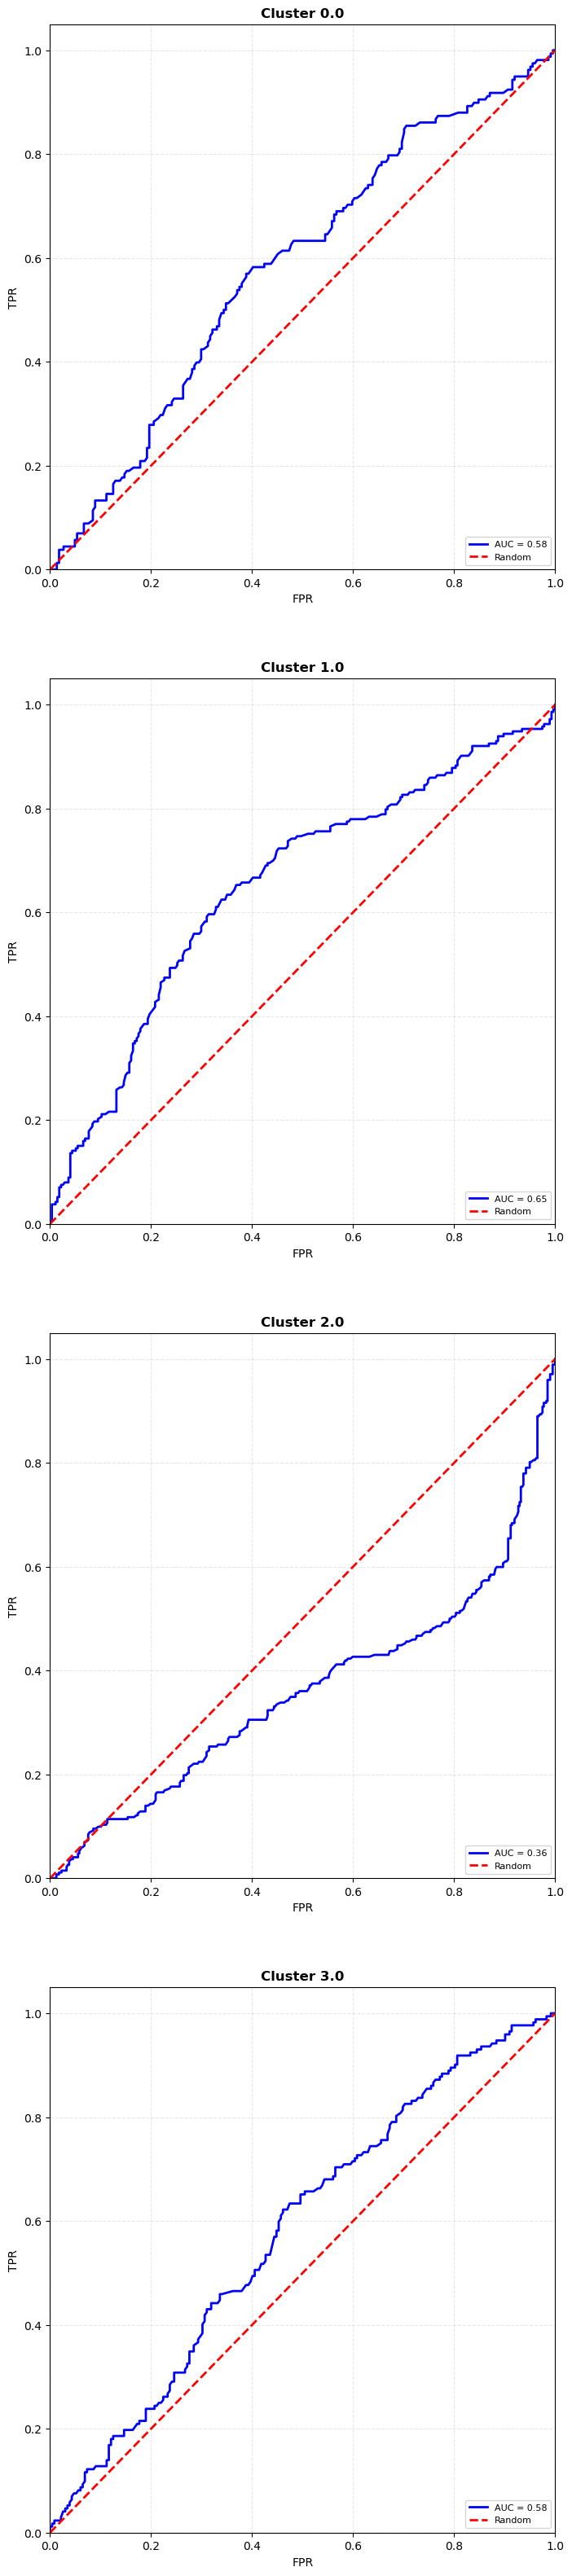

In [7]:
fig, axes = plt.subplots(len(df_best_by_louvain_cluster), 1, figsize=(8, 40))
axes = axes.flatten()

axis_idx = 0
for lv, df_best in df_best_by_louvain_cluster.items():
    print(f"Louvain Cluster {lv}: Best poses shape: {df_best.shape}")
    df_roc = df_best.to_pandas()
    df_roc['label'] = df_roc['sample_type'].map({'positive': 1, 'negative_balanced': 0})
    df_roc['scores'] = df_roc[SCORE_COL]
    scores = -df_roc['scores'] if INVERT_SCORES else df_roc['scores']
    fpr, tpr, _ = roc_curve(df_roc['label'], scores)
    roc_auc = auc(fpr, tpr)
    print(f"   Sample type distribution:\n{df_roc['sample_type'].value_counts()}\n")
    print(f"   AUC for GNINA_Score: {roc_auc:.3f}\n")

    axes[axis_idx].plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
    axes[axis_idx].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
    axes[axis_idx].set_title(f'Cluster {lv}', fontsize=12, fontweight='bold')
    axes[axis_idx].set_xlabel('FPR', fontsize=10)
    axes[axis_idx].set_ylabel('TPR', fontsize=10)
    axes[axis_idx].legend(loc='lower right', fontsize=8)
    axes[axis_idx].grid(alpha=0.3, linestyle='--')
    axes[axis_idx].set_xlim([0.0, 1.0])
    axes[axis_idx].set_ylim([0.0, 1.05])
    axis_idx += 1

plt.show()